# General Utility Functions for Data Conversion and Analysis at 6-ID-B

All functions utilized in this notebook are found in ``utils.py``. The proper dependencies have been installed in the conda environment ``xiu-wf``. To activate this environment in the terminal (for running other Python scripts), use the command ```conda activate xiu-wf```. To use this environment as the Python kernel for this Jupyter notebook, select "xiu-wf" in the top righthand corner of the VSCode window.

The focus of this workflow is to showcase (a) how to load spec data in Python, (b) plot and analyze 1D spec data, (c) convert 2D area detector data into reciprocal space, and (d) plot and analyze 3D reciprocal space volumes.

In [1]:
%gui qt

import numpy as np # For general data manipulation

import matplotlib # For static 2D plotting
import matplotlib.pyplot as plt
from mayavi import mlab # For interactive 3D plotting

from spec2nexus import spec # For parsing through spec data files

import utils # For local functions

# Prerequisites for leveraging mayavi's 3D plotting windows
matplotlib.use("Qt5Agg")
matplotlib.interactive(True)

In [2]:
# Files paths for spec data and XML configuration files
# Spec data can be read in without valid XML files, which are used for reciprocal space conversion
spec_file_path = "pm_npt/pmn_pt011_2_1.spec"
instrument_config_path = "pm_npt/6IDB_Instrument_yPrimary_6IDB.xml"
detector_config_path = "pm_npt/6IDB_Nanostrain_DetectorGeometry_740mm.xml"

## Loading spec data

Spec column data is loaded using the Python package ``spec2nexus``.

Documentation is here: https://spec2nexus.readthedocs.io/en/latest/

In [3]:
# Loads a spec data file
spec_file = spec.SpecDataFile(spec_file_path)


In [4]:
scan_number = 837

for item in list(spec_file.getScan(scan_number).data.keys()):
    print(item)

Eta
H
K
L
Alpha
Beta
Epoch
Seconds
APD
Ion_Ch_2
Ion_Ch_3
Ion_Ch_4
Ion_Ch_5
Detector
trod
Ringcurrent
scan_bar
Ion_Ch_7
volt
curr
ROI0
ROI0c
Temp_con
Temp_sam
ccd_tot
Gamry_I
Gamry_V
icr
ocr
ccd_sig
imtot
immax
imroi2
imroi3
imroi4
transm
filters
corrdet
offset_mono
ROI1
ROI1c
cap
loss
ac_array
LI1iv
LI1ov
LI1ampv
Rbv1
Rbv2
LI2ampv
LI1R
xroi1
xroi1c
xroi2
xroi2c
xsp_ocr
imroi1


In [5]:
fig, ax = utils.plot_spec_scan(scan_number, spec_file)

## Loading image data for a spec scan

In [6]:
scan_number = 837
scan_image_directory = "pm_npt/images/pmn_pt011_2_1/S" + str(scan_number)
scan = spec_file.getScan(scan_number)

# Utility function to read raw tiff images and convert the set of images into a 3D numpy array
# Output dimensions are (number_of_scans, detector_dim_1, detector_dim_2)
raw_image_data = utils.get_raw_image_data(
    spec_scan=scan,
    instr_config_path=instrument_config_path,
    image_dir=scan_image_directory
)

## Constructing reciprocal space map for a spec scan



In [7]:
# Utility function to generate the HKL position for every point in the raw image data above
# Output dimensions are (number_of_scans, detector_dim_1, detector_dim_2, 3 (H, K, L))
rsm = utils.create_rsm(
    spec_scan=scan, 
    instr_config_path=instrument_config_path, 
    det_config_path=detector_config_path
)

## Converting raw image data to reciprocal space

Creating a reciprocal space volume of a scan's image data requires 2 input values from the user:

- (1) The output shape of the 3D volume. This shape is a 3-value tuple that define the number of pixels in the H, K, and L directions, respectively.

- (2) H, K, L extents for the output volume.

The output from gridding the raw image data to reciprocal space is (1) a 3D numpy array containing the data and (2) a list containing the gridded coordinates for H, K, and L respectively.

In [8]:
rsm_data_shape = (200, 200, 500)

# Auto-generated bounds for RS-mapped data
h_min, h_max = np.amin(rsm[:,:,:,0]), np.amax(rsm[:,:,:,0])
k_min, k_max = np.amin(rsm[:,:,:,1]), np.amax(rsm[:,:,:,1])
l_min, l_max = np.amin(rsm[:,:,:,2]), np.amax(rsm[:,:,:,2])

rsm_data_bounds = [(h_min, h_max), (k_min, k_max), (l_min, l_max)]

rsm_data, rsm_data_coords = utils.grid_data(
    raw_image_data=raw_image_data,
    rsm=rsm,
    shape=rsm_data_shape,
    bounds=rsm_data_bounds
)

## 1D spec plotting

### Plotting spec column data

/Users/gfabbris/Desktop/xiu-workflow/utils.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


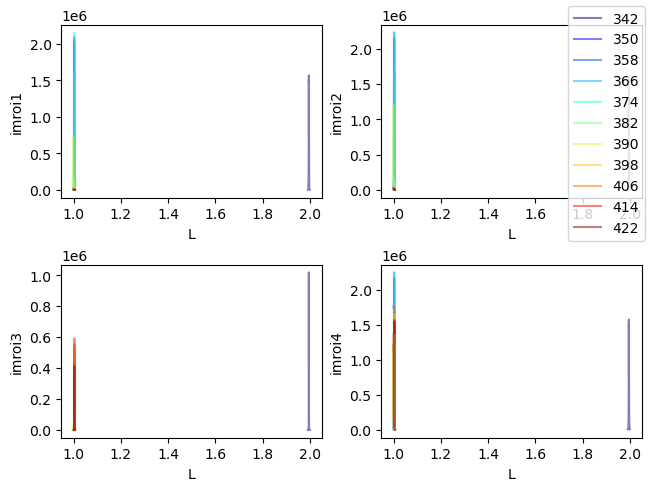

In [9]:
%matplotlib inline
scans = list(range(342, 430))[0::8]
x="L"
data_columns = ["imroi1", "imroi2", "imroi3", "imroi4"]
utils.plot_1d_data(
    spec_data_file=spec_file,
    scans=scans,
    x=x,
    y=data_columns
)

### Plotting FWHM, centroid, amplitude for a list of spec scans

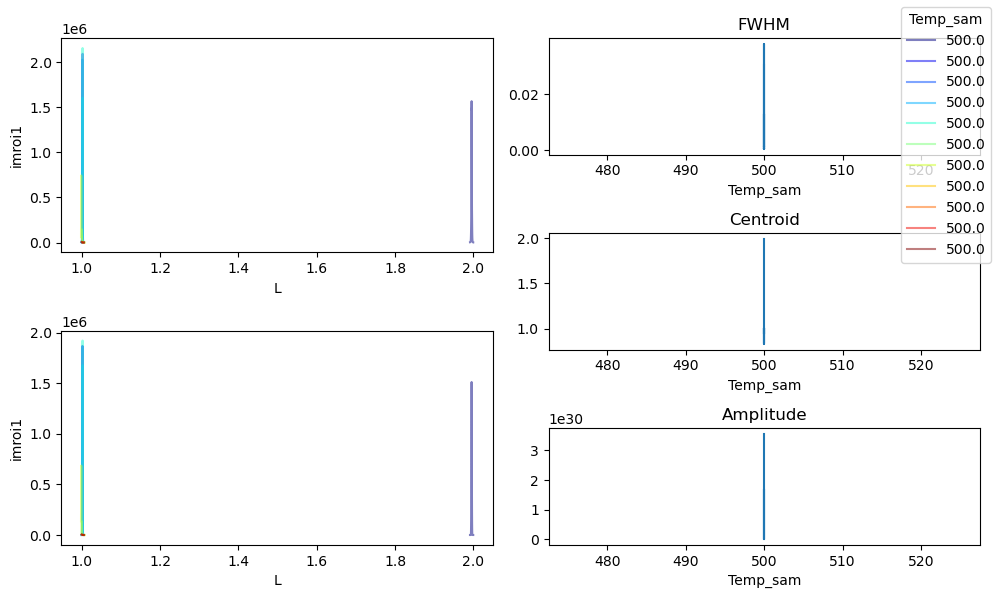

In [11]:
%matplotlib inline
scans = list(range(342, 430))[0::8]

x="L"
y="imroi1"
z="Temp_sam"

utils.plot_fwhm_cent_auc(
    spec_data_file=spec_file,
    scans=scans,
    x=x,
    y=y,
    z=z
)

### Plotting d-spacing and strain % for a list of spec scans

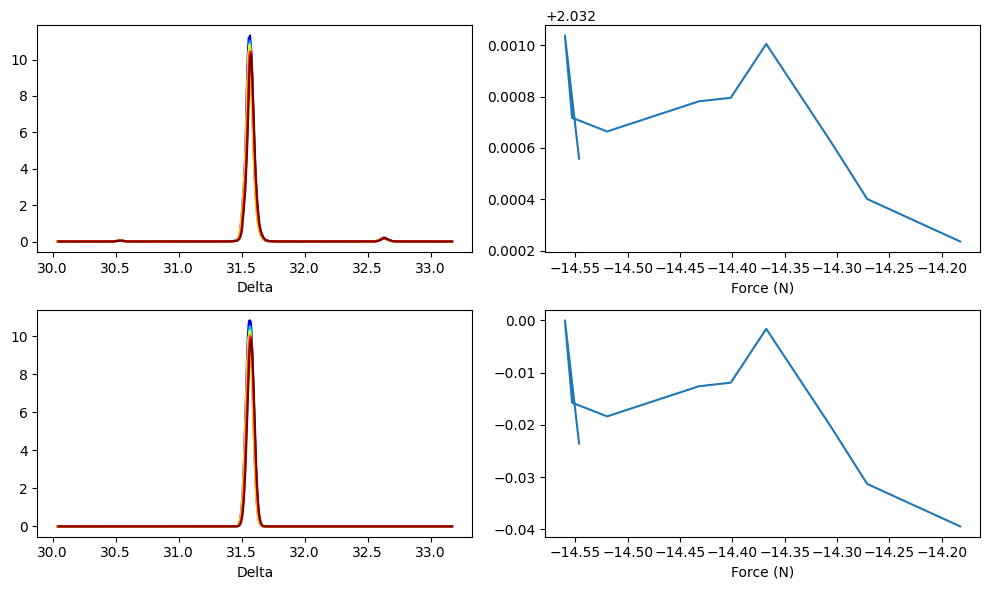

In [9]:
%matplotlib inline

scans = [166, 171, 181, 186, 195, 200, 205, 210, 215, 220]

photon_energy = 11.212 #keV
wavelength = 12.398 / photon_energy
offset = 0

utils.plot_strain_series(
    spec_data_file=spec_file,
    scans=scans,
    wavelength=wavelength,
    offset=offset,
    x_val="force"
)


## RSM image data plotting

### Plotting orthogonal 2D slices

In [10]:
rsm_data_bounds

[(-0.03407236689917556, 0.025476092219878486),
 (0.8780944255045247, 1.1495686409521408),
 (2.4275359727669854, 3.5529869037164152)]

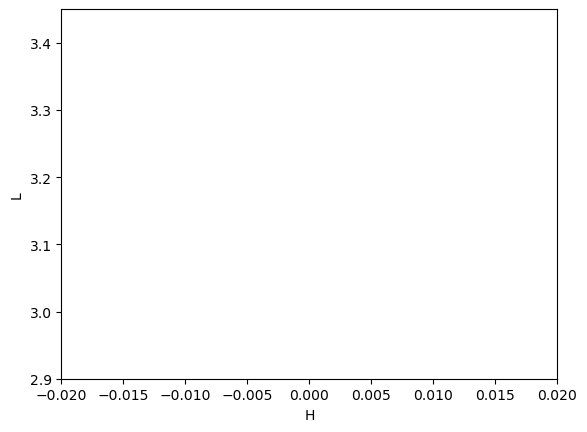

In [12]:
%matplotlib inline
utils.plot_2d_orthogonal_slice(
    data=rsm_data,
    coords=rsm_data_coords,
    x=(-0.02, 0.02),
    y=1,
    z=(2.9,3.45),
    scale="log",
    contour=False,
    cmap="jet",
    axes=["H", "K", "L"]
)

### Plotting 3D isosurface volumes

In [13]:
# Isosurface (contour)
%matplotlib qt
utils.plot_3d_isosurface(rsm_data, contours=30, alpha=0.05, cmap="jet")

### Plotting 1D line cuts for a list of scans

In [13]:
rsm_data_bounds

[(-0.03407236689917556, 0.025476092219878486),
 (0.8780944255045247, 1.1495686409521408),
 (2.4275359727669854, 3.5529869037164152)]

In [14]:
utils.cap_to_force(1.602, 300)

96.6582798973775

In [14]:
'''%matplotlib inline

scans = [166, 171]
z = "Temp_sam"
point_1 = (0, 1.00, 2.7) # (H, K, L)
point_2 = (0, 1.00, 3.3) # (H, K, L)


utils.plot_1d_line_cuts(
    spec_data_file=spec_file,
    scans=scans,
    point_1=point_1,
    point_2=point_2,
    z_val=z,
    instr_config_path=instrument_config_path, 
    det_config_path=detector_config_path,
    plot_3d=False,
    radius=2,
    log_scale=False
)
'''
"""The function is not working properly. The end goal was to plot a series of
line cuts (with a pixel radius) w.r.t. specific HKL endpoints. Error could be
in either the data-smoothing step or in the matplotlib axis creation step.
Apologies for the messy functions. This was a last-minute hack job. 

Best of luck, 
Henry
"""


'The function is not working properly. The end goal was to plot a series of\nline cuts (with a pixel radius) w.r.t. specific HKL endpoints. Error could be\nin either the data-smoothing step or in the matplotlib axis creation step.\nApologies for the messy functions. This was a last-minute hack job. \n\nBest of luck, \nHenry\n'